# YOLOv5 (fully pretrained model)

In [ ]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch
from IPython.display import Image, clear_output  # to display images
import requests
from PIL import Image

# Load the YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)  # You can choose 'yolov5m', 'yolov5l', or 'yolov5x' for larger models

!pip install torch torchvision torchaudio
!pip install matplotlib
#!pip install opencv-python-headless # sometimes 'opencv-python' does not work properly in Google Colab environments

!git clone https://github.com/ultralytics/yolov5  # Clone YOLOv5 repository
%cd yolov5
!pip install -r requirements.txt  # Install dependencies

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-11-3 Python-3.10.12 torch-2.1.0+cu118 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 99.4MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Cloning into 'yolov5'...
remote: Enumerating objects: 16048, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 16048 (delta 45), reused 44 (delta 25), pack-reused 15967
Receiving objects: 100% (16048/16048), 14.61 MiB | 14.64 MiB/s, done.
Resolving deltas: 100% (11011/11011), done.
/content/yolov5/yolov5


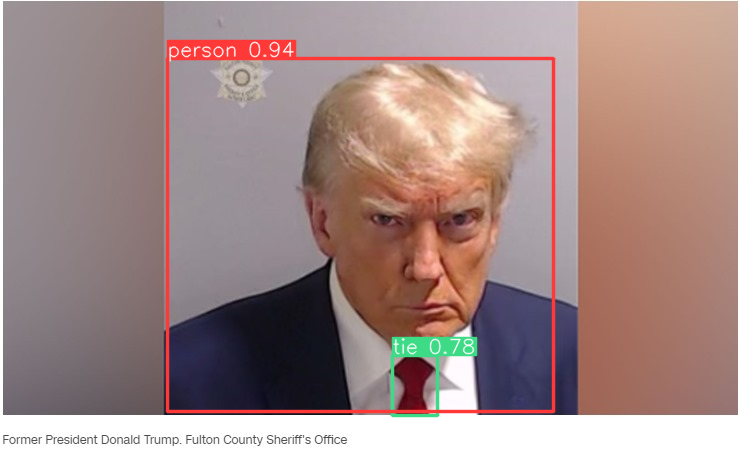

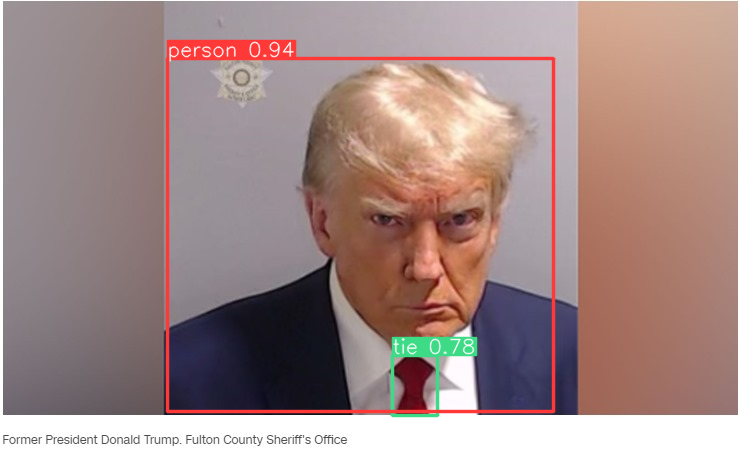

Bounding box 1: [     167.38      58.541       553.7      411.06     0.93555           0]
Confidence score: 0.9355528950691223
Class ID: 0.0
Bounding box 2: [     392.69      355.64      437.45      415.04      0.7817          27]
Confidence score: 0.7817042469978333
Class ID: 27.0
         xmin        ymin        xmax        ymax  confidence  class    name
0  167.375702   58.540775  553.696960  411.062500    0.935553      0  person
1  392.692474  355.635406  437.451324  415.043915    0.781704     27     tie


In [ ]:
# Let's assume you uploaded an image to your Colab session named 'image.jpg'
img_path = '/content/trump.jpeg'  # Change this to the path of your uploaded image

# Use the model to perform inference on the image
results = model(img_path)

# Results contain bounding boxes and labels for detections
# You can visualize the results using the 'show' method
results.show()

# Download an image from the web
img_url = 'http://images.cocodataset.org/val2017/000000039769.jpg'  # Replace with your image URL
img_data = requests.get(img_url).content
with open('image.jpg', 'wb') as handler:
    handler.write(img_data)

# Now you have the image saved as 'image.jpg', you can process it with the YOLO model
results = model('/content/trump.jpeg')
results.show()


# Results are in the 'results.xyxy[0]' tensor if you want to get bounding box coordinates
for i in range(len(results.xyxy[0])):
    print(f"Bounding box {i+1}: {results.xyxy[0][i].numpy()}")
    print(f"Confidence score: {results.xyxy[0][i][4].item()}")
    print(f"Class ID: {results.xyxy[0][i][5].item()}")

# You can also print the results as a pandas DataFrame
print(results.pandas().xyxy[0])

# YOLO (custom implementation)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import xml.etree.ElementTree as ET
import os

!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xf VOCtrainval_11-May-2012.tar

--2023-11-08 19:37:12--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  34.0MB/s    in 51s     

2023-11-08 19:38:03 (37.1 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [2]:
for file in os.listdir('/content/VOCdevkit/VOC2012/Annotations'):
  if file.endswith('.xml')==False:
    print(1)

In [3]:
# Preparing the dataset

directory = 'VOCdevkit/VOC2012/Annotations'

def parser(directory):
    img_annotations = {}
    label_map = {
        'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3,
        'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8,
        'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12,
        'motorbike': 13, 'person': 14, 'pottedplant': 15,
        'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19
    }

    for file in os.listdir(directory):
        if file.endswith('.xml'):
            file_path = os.path.join(directory, file)

            try:
                tree = ET.parse(file_path)
                root = tree.getroot()
            except ET.ParseError:
                print(f'Error parsing {file}')
                continue

            boxes = []
            for obj in root.findall('object'):
                label = obj.find('name').text
                box = obj.find('bndbox')

                if label is None or box is None:
                  print(f'The information is abscent for {file}')
                  continue

                try:
                    xmin = int(round(float(box.find('xmin').text)))
                    ymin = int(round(float(box.find('ymin').text)))
                    xmax = int(round(float(box.find('xmax').text)))
                    ymax = int(round(float(box.find('ymax').text)))
                except (TypeError, ValueError):
                    print(f'Exception appeared for {file}')
                    continue

                boxes.append({
                    'label': label_map.get(label, -1),
                    'xmin': xmin,
                    'ymin': ymin,
                    'xmax': xmax,
                    'ymax': ymax
                })

            if boxes:
                img_annotations[file[:-4]] = boxes

    return img_annotations, label_map

annotations, labels = parser(directory)
inverse_label_map = {v: k for k, v in labels.items()}
print(annotations.get('2012_000051'))

[{'label': 14, 'xmin': 9, 'ymin': 206, 'xmax': 33, 'ymax': 261}, {'label': 14, 'xmin': 103, 'ymin': 201, 'xmax': 123, 'ymax': 245}]


In [4]:
# Preparing the data for YOLO
def transform_annotation(image_width, image_height, boxes, S=7, B=2, C=20):
  target = torch.zeros((S, S, B * 5 + C))
  cell_size = 1.0 / S

  for box in boxes:
    label = box['label']
    x_center = (box['xmin'] + box['xmax']) / 2 / image_width
    y_center = (box['ymin'] + box['ymax']) / 2 / image_height
    width = (box['xmax'] - box['xmin']) / image_width
    height = (box['ymax'] - box['ymin']) / image_height

    grid_x = int(x_center / cell_size)
    grid_y = int(y_center / cell_size)

    for b in range(B):
      if target[grid_x, grid_y, b * 5 + 4] == 0:
        target[grid_x, grid_y, b * 5 : b * 5 + 5] = torch.tensor([x_center, y_center, width, height, 1])
        target[grid_x, grid_y, B * 5 + label] = 1
        break

  return target

In [5]:
from torchvision import transforms
from PIL import Image
import os

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class YOLODataset(Dataset):
    def __init__(self, annotation_dir, image_dir, S=7, B=2, C=20, transform=None):
        # The parser function returns two values, annotations and label_map
        annotations, self.label_map = parser(annotation_dir)  # separate them here
        self.annotations = annotations  # This should be just the annotations dictionary
        self.image_dir = image_dir
        self.S = S
        self.B = B
        self.C = C
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image_id, boxes = list(self.annotations.items())[idx]
        image_path = os.path.join(self.image_dir, f'{image_id}.jpg')
        image = Image.open(image_path).convert('RGB')  # Make sure this is a PIL image

        # Get the dimensions before applying transformations that convert to a tensor
        image_width, image_height = image.size

        # Apply the transformations
        if self.transform:
            image = self.transform(image)  # Now image is a tensor after this transformation

        # Now you can no longer access image.size directly since image is a tensor
        # image_width and image_height from before are used to create the target
        target = transform_annotation(image_width, image_height, boxes, self.S, self.B, self.C)

        return image, target

In [6]:
transform = transforms.Compose([
    transforms.Resize((448, 448)),   # Choosing the size like in the original paper for YOLOv1
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

dataset = YOLODataset(
    annotation_dir = directory,
    image_dir = '/content/VOCdevkit/VOC2012/JPEGImages',
    transform = transform
)

data_loader = DataLoader(dataset, batch_size = 5, shuffle=True)

In [ ]:
data_loader

In [7]:
from torch.nn.modules.activation import LeakyReLU
# Defining the CNN

import torch.nn as nn
import torch.nn.functional as f

class CustomYOLOCNN(nn.Module):
  def __init__(self, S=7, B=2, C=20):
    super(CustomYOLOCNN, self).__init__()
    self.S = S
    self.B = B
    self.C = C

    # In the original paper  YOLO had 24 convolutional layers and 2 fully connected ones

    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=2),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=2),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=2),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    with torch.no_grad():
        dummy_input = torch.zeros((1, 3, 448, 448))  # Use the size of your input images
        dummy_features = self.features(dummy_input)
        self._linear_input_features = dummy_features.view(1, -1).shape[1]

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(self._linear_input_features, 4096),
        nn.LeakyReLU(0.1),
        nn.Dropout(0.5),
        nn.Linear(4096, S * S * (C + B * 5))
        )

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    # Reshape x to the target's shape
    x = x.view(-1, self.S, self.S, (self.B * 5 + self.C))  # Reshape to the correct shape
    return x

In [8]:
model = CustomYOLOCNN()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
from torch.utils.data import DataLoader

class YOLOTrainer:
    def __init__(self, model, dataloader: DataLoader, criterion, optimizer, device):
        self.model = model
        self.dataloader = dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def train_epoch(self, epoch):
        self.model.train()  # Set the model to training mode
        running_loss = 0.0

        for i, (images, targets) in enumerate(self.dataloader):
            images, targets = images.to(self.device), targets.to(self.device)

            # Zero the parameter gradients
            self.optimizer.zero_grad()

            # Forward pass
            outputs = self.model(images)

            # Compute the loss
            loss = self.compute_loss(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            self.optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 10 == 9:  # Print every 10 mini-batches
                print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 10}')
                running_loss = 0.0

        # Save a checkpoint at the end of each epoch
        self.save_checkpoint(epoch)

    def save_checkpoint(self, epoch, filename='yolo_checkpoint.pth.tar'):
        state = {
            'epoch': epoch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
        }
        torch.save(state, filename)

    def train(self, epochs):
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')
            self.train_epoch(epoch)  # Pass the epoch number to train_epoch
            print('--------------------------------')

    def compute_loss(self, outputs, targets):
        # Implement the YOLO-specific loss calculation here
        return self.criterion(outputs, targets)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

trainer = YOLOTrainer(model, data_loader, criterion, optimizer, device)
trainer.train(epochs=5)

Epoch 1/5
Epoch: 1, Batch: 10, Loss: 0.005277747847139835
Epoch: 1, Batch: 20, Loss: 0.004140030406415462
Epoch: 1, Batch: 30, Loss: 0.00351580698043108
Epoch: 1, Batch: 40, Loss: 0.005173895694315434
Epoch: 1, Batch: 50, Loss: 0.004663614952005446
Epoch: 1, Batch: 60, Loss: 0.005176891013979912
Epoch: 1, Batch: 70, Loss: 0.004183094599284232
Epoch: 1, Batch: 80, Loss: 0.0044530195649713274
Epoch: 1, Batch: 90, Loss: 0.004580842703580857
Epoch: 1, Batch: 100, Loss: 0.0046660379273816945
Epoch: 1, Batch: 110, Loss: 0.0037723534274846315
Epoch: 1, Batch: 120, Loss: 0.0038605267414823174
Epoch: 1, Batch: 130, Loss: 0.004419382428750396
Epoch: 1, Batch: 140, Loss: 0.004639475978910923
Epoch: 1, Batch: 150, Loss: 0.004912246763706207
Epoch: 1, Batch: 160, Loss: 0.004935159464366734
Epoch: 1, Batch: 170, Loss: 0.003975197509862483
Epoch: 1, Batch: 180, Loss: 0.004523390880785882
Epoch: 1, Batch: 190, Loss: 0.005010550678707659
Epoch: 1, Batch: 200, Loss: 0.004125365102663636
Epoch: 1, Batch:

In [ ]:
file_path = '/content/VOCdevkit/VOC2012/JPEGImages'

if os.path.exists(file_path):
    print(f"The file exists: {file_path}")
else:
    print(f"The file does not exist: {file_path}")


The file exists: /content/VOCdevkit/VOC2012/JPEGImages


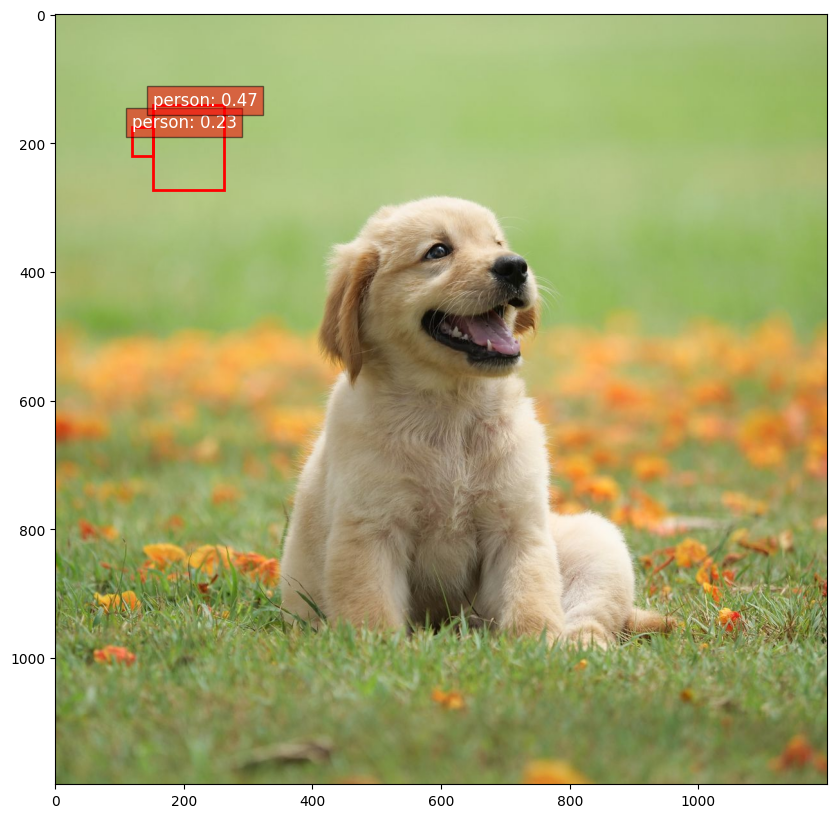

In [21]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the trained model from the checkpoint
def load_trained_model(model_path):
    model = CustomYOLOCNN()  # Instantiate your model architecture
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()  # Set the model to evaluation mode
    return model

# Preprocess the input image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((448, 448)),
        transforms.ToTensor()
    ])
    image = transform(image)
    return image

def decode_predictions(predictions, S=7, B=2, C=20, threshold=0.2):
    """
    Decodes the predictions of the YOLO model.

    Args:
    - predictions: the output tensor from the YOLO model
    - S, B, C: the dimensions of the prediction grid (SxS grid, B bounding boxes, C classes)
    - threshold: the threshold for considering detected objects

    Returns:
    - A list of dictionaries containing boxes with labels and coordinates
    """
    predictions = predictions.reshape(-1, S, S, B*5 + C)
    boxes = []
    for i in range(S):
        for j in range(S):
            for b in range(B):
                box_data = predictions[0, i, j, b*5:(b+1)*5]
                confidence = box_data[4]
                if confidence < threshold:
                    continue

                # Get the class label with the highest score
                class_probs = predictions[0, i, j, B*5:]
                class_label = torch.argmax(class_probs).item()

                # Convert coordinates
                cell_size = 448 / S  # Assuming input images are resized to 448x448
                x_center = (box_data[0] + j) * cell_size
                y_center = (box_data[1] + i) * cell_size
                width = box_data[2] * 448
                height = box_data[3] * 448

                xmin = x_center - width / 2
                ymin = y_center - height / 2
                xmax = x_center + width / 2
                ymax = y_center + height / 2

                boxes.append({
                    'label': class_label,
                    'confidence': confidence.item(),
                    'xmin': max(0, int(xmin)),
                    'ymin': max(0, int(ymin)),
                    'xmax': min(448, int(xmax)),  # Make sure the box doesn't go out of the image
                    'ymax': min(448, int(ymax))
                })

    # Here you would typically apply Non-Maximum Suppression (NMS) to reduce overlapping boxes
    # But for simplicity, we're skipping this step

    return boxes

# Function to draw bounding boxes on the image
def draw_boxes(original_image, boxes, class_map):
    plt.figure(figsize=(10, 10))
    plt.imshow(original_image)
    ax = plt.gca()

    # For each box, add a rectangle and label - this is an example, adjust according to your decode_predictions function
    for box in boxes:
        label = class_map[box['label']]
        confidence = box['confidence']
        xmin, ymin, xmax, ymax = box['xmin'], box['ymin'], box['xmax'], box['ymax']
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin, f"{label}: {confidence:.2f}", color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

# Path to the model checkpoint and image file
model_path = '/content/yolo_checkpoint.pth.tar'
image_path = '/content/dog-photo.jpg'

# Load the model and preprocess the image
model = load_trained_model(model_path)
input_image = preprocess_image(image_path)

# Assuming you have a function that can decode the raw model output into bounding boxes
with torch.no_grad():
    predictions_tensor = model(input_image.unsqueeze(0))  # Add a batch dimension
boxes = decode_predictions(predictions_tensor)  # Decode predictions

# Draw the boxes on the original image
original_image = Image.open(image_path).convert('RGB')  # Convert image to RGB
draw_boxes(original_image, boxes, inverse_label_map)



# References
* ["You Only Look Once:
Unified, Real-Time Object Detection"
](https://arxiv.org/pdf/1506.02640.pdf) (Original paper for YOLOv1)